In [1]:
%load_ext autoreload
%autoreload 2

import torch
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import pickle
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import h5py
from torchsummary import summary
import pytorch_model_summary as pms
from tqdm import tqdm

# Autoencoder Model 

In [16]:
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv1d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv1d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_3 = nn.Conv1d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.attention_1 = nn.MultiheadAttention(n_step, 1)
        self.attention_2 = nn.MultiheadAttention(n_step, 1)
        self.attention_3 = nn.MultiheadAttention(n_step, 1)
        self.norm_1 = nn.LayerNorm([n_step])
        self.norm_2 = nn.LayerNorm([n_step])
        self.norm_3 = nn.LayerNorm([n_step])
        self.drop = nn.Dropout(p=0.2)
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.relu_3 = nn.ReLU()
        self.relu_4 = nn.ReLU()
        
    def forward(self,x_in):
        x_input = x_in
        x_k_v = x_input.transpose(0,1)
        x = self.cov1d_1(x_in)
        x = self.norm_1(x)
        x = self.relu_1(x)
        x = x.transpose(0,1)
        #implement self-attention layer
        x,_ = self.attention_1(x,x_k_v,x_k_v)
        x = x.transpose(0,1)
        
        x = self.cov1d_2(x)
        x = self.norm_2(x)
        x = self.relu_2(x)
        x = x.transpose(0,1)
        #implement self-attention layer
        x,_ = self.attention_2(x,x_k_v,x_k_v)
        x = x.transpose(0,1)
        
        x = self.cov1d_3(x)
        x = self.norm_3(x)
        x = self.relu_3(x)
        x = x.transpose(0,1)
        #implement self-attention layer
        x,_ = self.attention_3(x,x_k_v,x_k_v)
        x = x.transpose(0,1)
        
        x = self.relu_4(x)
        x = x.add(x_input)
        output = self.drop(x)
        
        return output
        
        

In [17]:
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv1d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.attention_1 = nn.MultiheadAttention(n_step, 1)
        self.norm_1 = nn.LayerNorm([n_step])
        self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x_in):
        x_input = x_in
        x_k_v = x_input.transpose(0,1)
        x = self.cov1d_1(x_in)
        x = self.norm_1(x)
        x = self.relu(x)
        x = x.transpose(0,1)
        #implement self-attention layer
        x,_ = self.attention_1(x,x_k_v,x_k_v)
        x = x.transpose(0,1)
        output = self.drop(x)
        
        return output
        
        

In [19]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.cov1d = nn.Conv1d(5,128,3,stride=1,padding=1,padding_mode = 'zeros')
#        self.cov1d_1 = nn.Conv1d(128,128,3,stride=1,padding=1,padding_mode = 'zeros')
        self.conv_block_1 = conv_block(t_size=128,n_step=40)
#         self.conv_block_2 = conv_block(t_size=128,n_step=100)
#         self.conv_block_3 = conv_block(t_size=128,n_step=50)
        self.iden_block_1 = identity_block(t_size=128,n_step=40)
#         self.iden_block_2 = identity_block(t_size=128,n_step=100)
#         self.iden_block_3 = identity_block(t_size=128,n_step=50)
        self.relu_1 = nn.ReLU()
#         self.relu_2 = nn.ReLU()
#         self.relu_3 = nn.ReLU()
        self.maxpool_1 = nn.MaxPool1d(2,stride=2)
#         self.maxpool_2 = nn.MaxPool1d(2,stride=2)
#         self.maxpool_3 = nn.MaxPool1d(2,stride=2)
#         self.lstm = nn.LSTM(25,32,batch_first=True,bidirectional=True)
        self.dense = nn.Linear(2560,36)
#        self.sd = nn.Linear(32,8)
#        self.logspike = nn.Linear(32,8)
        
    def forward(self,x):
        #x = x.view(-1,200,1)
        x = x.transpose(1,2)
        x = self.cov1d(x)
        x = self.iden_block_1(x)
        x = self.conv_block_1(x)
        x = self.maxpool_1(x)
#         x = self.iden_block_2(x)
#         x = self.conv_block_2(x)
#         x = self.maxpool_2(x)
#         x = self.iden_block_3(x)
#         x = self.conv_block_3(x)
#         x = self.maxpool_3(x)
#        x = self.cov1d_1(x)
#        x = x.transpose(1,2)
#         encode,(_,__) = self.lstm(x)
#         encode = encode[:,-1,:]
        x = x.view(-1,2560)
        selection = self.dense(x)
        selection = self.relu_1(selection)
#         mn = self.mn(encode)
#  #       mn = self.relu_1(mn)
#         sd = self.sd(encode)
#  #       sd = self.relu_2(sd)
#         std = torch.exp(sd*0.5).cuda()
#         eps = torch.normal(1,1,size=std.size()).cuda()
#         gaussian = eps.mul(std).add_(mn).cuda()
        
#         log_spike = -F.relu(-self.logspike(encode))
#         eta = torch.normal(1,1,size=std.size()).cuda()
#         selection = F.relu(50.0*(eta + log_spike.exp() - 1)).cuda()
#         selection = selection.mul(gaussian).cuda()
#         selection = self.relu_3(selection)
#        selection = selection.transpose(1,2)
#         x_sample = self.relu_3(x_sample)
#         x_sample = x_sample.transpose(1,2)
        
        return selection
        

In [20]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.cov1d_in = nn.Conv1d(36,128,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d = nn.Conv1d(128,5,3,stride=1,padding=1,padding_mode = 'zeros')
        self.conv_block_1 = conv_block(t_size=128,n_step=40)
#         self.conv_block_2 = conv_block(t_size=128,n_step=50)
#         self.conv_block_3 = conv_block(t_size=128,n_step=100)
#         self.conv_block_4 = conv_block(t_size=128,n_step=200)
        self.iden_block_1 = identity_block(t_size=128,n_step=40)
#         self.iden_block_2 = identity_block(t_size=128,n_step=50)
#         self.iden_block_3 = identity_block(t_size=128,n_step=100)
#         self.iden_block_4 = identity_block(t_size=128,n_step=200)
#         self.upsample_1 = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
#         self.upsample_2 = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
#         self.upsample_3 = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        

        
    def forward(self,x):
        x = x[:,:,None]
#        x = x.transpose(1,2)
        x = x.repeat([1,1,40])
#        print(x.shape)
        x = self.cov1d_in(x)
        x = self.iden_block_1(x)
        x = self.conv_block_1(x)
#         x = self.upsample_1(x)
#         x = self.iden_block_2(x)
#         x = self.conv_block_2(x)
#         x = self.upsample_2(x)
#         x = self.iden_block_3(x)
#         x = self.conv_block_3(x)
#         x = self.upsample_3(x)
#         x = self.iden_block_4(x)
#         x = self.conv_block_4(x)
        x = self.cov1d(x)
        x = x.transpose(1,2)
        #x = x.view(-1,40,5)
        
        return x
        

In [21]:
class VAE(nn.Module):
    
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        embedding = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize

        # decode
        predicted = self.dec(embedding)
        return predicted

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class Regularization(torch.nn.Module):
    def __init__(self,model,weight_decay,p=1):
        '''
      
        '''
        super(Regularization, self).__init__()
        if weight_decay < 0:
            print("param weight_decay can not <0")
            exit(0)
        self.model=model
        self.weight_decay=weight_decay
        self.p=p
        self.weight_list=self.get_weight(model)
 #       self.weight_info(self.weight_list)
 
    def to(self,device):
        '''
       
        :param device: cude or cpu
        :return:
        '''
        self.device=device
        super().to(device)
        return self
 
    def forward(self, model):
        self.weight_list=self.get_weight(model)#获得最新的权重
        reg_loss = self.regularization_loss(self.weight_list, self.weight_decay, p=self.p)
        return reg_loss
 
    def get_weight(self,model):
        '''
        
        :param model:
        :return:
        '''
        weight_list = []
        for name, param in model.named_parameters():
            if 'dec' in name and 'weight' in name:
                weight = (name, param)
                weight_list.append(weight)
        return weight_list
 
    def regularization_loss(self,weight_list, weight_decay, p):
        '''
        
        :param weight_list:
        :param p: 
        :param weight_decay:
        :return:
        '''
        # weight_decay=Variable(torch.FloatTensor([weight_decay]).to(self.device),requires_grad=True)
        # reg_loss=Variable(torch.FloatTensor([0.]).to(self.device),requires_grad=True)
        # weight_decay=torch.FloatTensor([weight_decay]).to(self.device)
        # reg_loss=torch.FloatTensor([0.]).to(self.device)
        reg_loss=0
        for name, w in weight_list:
            l2_reg = torch.norm(w, p=p)
            reg_loss = reg_loss + l2_reg
 
        reg_loss=weight_decay*reg_loss
        return reg_loss
 
    def weight_info(self,weight_list):
        '''
        
        :param weight_list:
        :return:
        '''
        print("---------------regularization weight---------------")
        for name ,w in weight_list:
            print(name)

In [24]:
class Entropy_Loss(nn.Module):
    def __init__(self, entroy_coe):
        super(Entropy_Loss, self).__init__()
        self.coe = entroy_coe

    def to(self, device):
        self.device = device
        super().to(device)
        return self

    def forward(self, x):
        en_loss = self.entropy_loss(x)
        return en_loss

    def entropy_loss(self, embedding):
        N = embedding.shape[1]
        N = torch.tensor(N).type(torch.float32)
        mask = embedding != 0
        mask1 = torch.sum(mask, axis=0)
        mask2 = mask1 != 0
        n = torch.sum(mask2).type(torch.float32)
        loss_min = (N // 2 + 1).lgamma().exp() ** 2 / (N + 1).lgamma().exp()
        loss = (N - n + 1).lgamma().exp() * (n + 1).lgamma().exp() / (N + 1).lgamma().exp()
        loss = loss - loss_min

        return self.coe * loss

In [141]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [26]:
torch.save(model,'DM3_New/3_17_new_model.pth')

/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type conv_block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type identity_block. It won't be checked for correctn

# load dm3 data

In [27]:
sub_stand = np.load('prosessedI.npy')

In [111]:
x_label = np.load('prosessedV.npy')

In [29]:
sub_stand = sub_stand.reshape(-1,40,5)

In [30]:
sub_stand.shape

(4110, 40, 5)

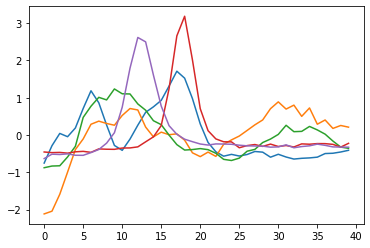

In [31]:
plt.plot(np.mean(sub_stand, axis =0))

In [23]:
train_iterator = torch.utils.data.DataLoader(sub_stand, batch_size = 512,shuffle = True)

In [32]:
def loss_function(model,
                  encoder,
                  decoder,
                  train_iterator,
                  optimizer,
                  coef = 0, 
                  coef1 = 0,
                  ln_parm = 1, 
                  beta = None):

    weight_decay = coef
    weight_decay_1 = coef1

    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0
    #    for i, x in enumerate(train_iterator):
    for x in tqdm(train_iterator, leave=True, total=len(train_iterator)):

        
        reg_loss_2 = Regularization(model, weight_decay_1, p=2).to(device)
     

        x = x.to(device, dtype=torch.float)

        # update the gradients to zero
        optimizer.zero_grad()

        if beta is None: 
        
          embedding = encoder(x)
        
        else:
        
          # forward pass
          #        predicted_x = model(x)
          embedding,sd,mn = encoder(x)
        
        if weight_decay > 0:
            reg_loss_1 = weight_decay * torch.norm(embedding, ln_parm).to(device)
        else:
            reg_loss_1 = 0.0 

        predicted_x = decoder(embedding)

        # reconstruction loss
        loss = F.mse_loss(x, predicted_x, reduction='mean')

        
        loss = loss +  reg_loss_1 +reg_loss_2(model) 
#         Eloss = entropy_loss(embedding)
#         loss = loss + Eloss
#         entropyloss = entropyloss + Eloss
        
        
            
        if beta is not None:
            vae_loss = beta * 0.5 * torch.sum(torch.exp(sd) + (mn)**2 - 1.0 - sd).to(device)
            vae_loss/= (sd.shape[0]*sd.shape[1])
        else:
            vae_loss=0

        loss = loss + vae_loss
        
        # backward pass
        train_loss += loss.item()

        loss.backward()
        # update the weights
        optimizer.step()

    return train_loss

In [33]:
def Train(model,encoder,decoder,train_iterator,optimizer,
          epochs, coef=0,coef_1=0,ln_parm=1, beta=None):
    
    N_EPOCHS = epochs
    best_train_loss = float('inf')
    
    for epoch in range(N_EPOCHS):

        train = loss_function(model,encoder,decoder,train_iterator,
                              optimizer,coef,coef_1,ln_parm,beta)
        train_loss = train
        train_loss /= len(train_iterator)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')
        print('.............................')

        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                "encoder": encoder.state_dict(), 
                'decoder': decoder.state_dict()
            }
            if epoch > 10:
                torch.save(checkpoint, f'DM3_New/3.17_new_model.pkl')
            
#             elif epoch < 1000:
                
#                 torch.save(checkpoint, f'DM3_New/simple_l1=3e-5_2000.pkl')
                
#             else:
#                 torch.save(checkpoint, f'DM3_New/simple_l1=3e-5_>2000.pkl')

In [21]:
Train(model,encoder,decoder,train_iterator,optimizer,5000,coef=1e-5,coef_1=1e-5)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Train Loss: 1.0124
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1.0052
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.9837
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3, Train Loss: 1.0023
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.9935
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.9890
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.9860
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.9747
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.9495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.9008
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.8433
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.7780
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.7481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.7135
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.6867
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.6450
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.6115
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.6137
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.5771
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.5566
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.5337
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.5211
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.5009
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.5270
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.4786
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.4715
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.4653
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.4598
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.4572
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29, Train Loss: 0.4774
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30, Train Loss: 0.4578
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31, Train Loss: 0.4672
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32, Train Loss: 0.4499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33, Train Loss: 0.4738
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34, Train Loss: 0.4389
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35, Train Loss: 0.4531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36, Train Loss: 0.4583
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37, Train Loss: 0.4696
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38, Train Loss: 0.4281
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39, Train Loss: 0.4297
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40, Train Loss: 0.4420
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41, Train Loss: 0.4146
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42, Train Loss: 0.4330
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43, Train Loss: 0.4200
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44, Train Loss: 0.4165
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45, Train Loss: 0.3842
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46, Train Loss: 0.3826
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47, Train Loss: 0.3481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48, Train Loss: 0.3344
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49, Train Loss: 0.3024
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50, Train Loss: 0.2954
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51, Train Loss: 0.2627
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52, Train Loss: 0.2577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53, Train Loss: 0.2431
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54, Train Loss: 0.2392
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55, Train Loss: 0.2317
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56, Train Loss: 0.2300
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57, Train Loss: 0.2250
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58, Train Loss: 0.2207
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59, Train Loss: 0.2164
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60, Train Loss: 0.2190
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 61, Train Loss: 0.2148
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 62, Train Loss: 0.2149
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 63, Train Loss: 0.2154
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 64, Train Loss: 0.2108
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 65, Train Loss: 0.2170
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 66, Train Loss: 0.2135
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 67, Train Loss: 0.2167
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 68, Train Loss: 0.2106
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 69, Train Loss: 0.2083
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 70, Train Loss: 0.2106
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 71, Train Loss: 0.2076
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 72, Train Loss: 0.2122
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 73, Train Loss: 0.2073
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 74, Train Loss: 0.2117
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 75, Train Loss: 0.2084
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 76, Train Loss: 0.2073
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 77, Train Loss: 0.2090
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 78, Train Loss: 0.2069
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 79, Train Loss: 0.2058
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 80, Train Loss: 0.2095
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 81, Train Loss: 0.2071
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 82, Train Loss: 0.2055
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 83, Train Loss: 0.2055
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 84, Train Loss: 0.2070
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 85, Train Loss: 0.2044
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 86, Train Loss: 0.2089
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 87, Train Loss: 0.2140
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 88, Train Loss: 0.2051
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 89, Train Loss: 0.2041
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 90, Train Loss: 0.2027
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 91, Train Loss: 0.2019
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 92, Train Loss: 0.2049
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 93, Train Loss: 0.2095
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 94, Train Loss: 0.2045
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 95, Train Loss: 0.2031
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 96, Train Loss: 0.2019
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 97, Train Loss: 0.2036
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 98, Train Loss: 0.2030
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 99, Train Loss: 0.2035
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 100, Train Loss: 0.2016
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 101, Train Loss: 0.2003
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 102, Train Loss: 0.2022
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 103, Train Loss: 0.1995
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 104, Train Loss: 0.2020
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 105, Train Loss: 0.2007
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 106, Train Loss: 0.2062
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 107, Train Loss: 0.2053
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 108, Train Loss: 0.2005
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 109, Train Loss: 0.2007
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 110, Train Loss: 0.2018
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 111, Train Loss: 0.1988
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 112, Train Loss: 0.2050
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 113, Train Loss: 0.2029
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 114, Train Loss: 0.2013
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 115, Train Loss: 0.2031
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 116, Train Loss: 0.2006
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 117, Train Loss: 0.2024
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 118, Train Loss: 0.2005
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 119, Train Loss: 0.1975
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 120, Train Loss: 0.1994
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 121, Train Loss: 0.2000
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 122, Train Loss: 0.1978
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 123, Train Loss: 0.2003
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 124, Train Loss: 0.1988
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 125, Train Loss: 0.1995
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 126, Train Loss: 0.1970
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 127, Train Loss: 0.2008
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 128, Train Loss: 0.2016
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 129, Train Loss: 0.2001
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 130, Train Loss: 0.1992
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 131, Train Loss: 0.1969
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 132, Train Loss: 0.1966
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 133, Train Loss: 0.1984
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 134, Train Loss: 0.2014
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 135, Train Loss: 0.1972
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 136, Train Loss: 0.2001
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 137, Train Loss: 0.1963
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 138, Train Loss: 0.2006
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 139, Train Loss: 0.2007
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 140, Train Loss: 0.2015
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 141, Train Loss: 0.1995
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 142, Train Loss: 0.1983
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 143, Train Loss: 0.1957
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 144, Train Loss: 0.2003
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 145, Train Loss: 0.1963
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 146, Train Loss: 0.2008
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 147, Train Loss: 0.1999
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 148, Train Loss: 0.1975
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 149, Train Loss: 0.1946
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 150, Train Loss: 0.1982
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 151, Train Loss: 0.1959
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 152, Train Loss: 0.1973
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 153, Train Loss: 0.1947
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 154, Train Loss: 0.1943
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 155, Train Loss: 0.1963
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 156, Train Loss: 0.1960
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 157, Train Loss: 0.1960
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 158, Train Loss: 0.1983
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 159, Train Loss: 0.1986
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 160, Train Loss: 0.1961
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 161, Train Loss: 0.1958
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 162, Train Loss: 0.1982
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 163, Train Loss: 0.1941
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 164, Train Loss: 0.1961
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 165, Train Loss: 0.2020
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 166, Train Loss: 0.2020
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 167, Train Loss: 0.1984
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 168, Train Loss: 0.1970
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 169, Train Loss: 0.1970
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 170, Train Loss: 0.1968
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 171, Train Loss: 0.1934
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 172, Train Loss: 0.1947
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 173, Train Loss: 0.1934
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 174, Train Loss: 0.1974
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 175, Train Loss: 0.1964
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 176, Train Loss: 0.1962
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 177, Train Loss: 0.1957
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 178, Train Loss: 0.1944
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 179, Train Loss: 0.1973
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 180, Train Loss: 0.1988
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 181, Train Loss: 0.1967
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 182, Train Loss: 0.1967
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 183, Train Loss: 0.1945
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 184, Train Loss: 0.1952
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 185, Train Loss: 0.1977
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 186, Train Loss: 0.1944
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 187, Train Loss: 0.1947
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 188, Train Loss: 0.1983
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 189, Train Loss: 0.1981
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 190, Train Loss: 0.1978
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 191, Train Loss: 0.1953
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 192, Train Loss: 0.1946
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 193, Train Loss: 0.1929
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 194, Train Loss: 0.1930
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 195, Train Loss: 0.1941
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 196, Train Loss: 0.1941
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 197, Train Loss: 0.1914
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 198, Train Loss: 0.1953
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 199, Train Loss: 0.2001
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 200, Train Loss: 0.1936
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 201, Train Loss: 0.1926
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 202, Train Loss: 0.1949
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 203, Train Loss: 0.1927
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 204, Train Loss: 0.1929
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 205, Train Loss: 0.1947
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 206, Train Loss: 0.1996
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 207, Train Loss: 0.1936
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 208, Train Loss: 0.1926
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 209, Train Loss: 0.1936
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 210, Train Loss: 0.1959
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 211, Train Loss: 0.1944
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 212, Train Loss: 0.1940
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 213, Train Loss: 0.1916
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 214, Train Loss: 0.1973
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 215, Train Loss: 0.1907
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 216, Train Loss: 0.1924
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 217, Train Loss: 0.1922
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 218, Train Loss: 0.1914
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 219, Train Loss: 0.1915
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 220, Train Loss: 0.1968
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 221, Train Loss: 0.1938
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 222, Train Loss: 0.1945
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 223, Train Loss: 0.1951
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 224, Train Loss: 0.1919
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 225, Train Loss: 0.1937
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 226, Train Loss: 0.1974
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 227, Train Loss: 0.1932
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 228, Train Loss: 0.1896
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 229, Train Loss: 0.1908
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 230, Train Loss: 0.1903
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 231, Train Loss: 0.1929
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 232, Train Loss: 0.1926
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 233, Train Loss: 0.1919
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 234, Train Loss: 0.1932
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 235, Train Loss: 0.1940
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 236, Train Loss: 0.1972
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 237, Train Loss: 0.1910
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 238, Train Loss: 0.1959
.............................


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 822, Train Loss: 0.1609
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 823, Train Loss: 0.1616
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 824, Train Loss: 0.1594
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 825, Train Loss: 0.1619
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 826, Train Loss: 0.1588
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 827, Train Loss: 0.1602
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 828, Train Loss: 0.1572
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 829, Train Loss: 0.1594
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 830, Train Loss: 0.1601
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 831, Train Loss: 0.1590
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 832, Train Loss: 0.1592
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 833, Train Loss: 0.1585
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 834, Train Loss: 0.1640
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 835, Train Loss: 0.1583
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 836, Train Loss: 0.1610
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 837, Train Loss: 0.1592
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 838, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 839, Train Loss: 0.1648
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 840, Train Loss: 0.1590
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 841, Train Loss: 0.1589
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 842, Train Loss: 0.1670
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 843, Train Loss: 0.1607
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 844, Train Loss: 0.1582
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 845, Train Loss: 0.1603
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 846, Train Loss: 0.1602
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 847, Train Loss: 0.1588
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 848, Train Loss: 0.1614
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 849, Train Loss: 0.1607
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 850, Train Loss: 0.1595
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 851, Train Loss: 0.1584
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 852, Train Loss: 0.1601
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 853, Train Loss: 0.1578
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 854, Train Loss: 0.1595
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 855, Train Loss: 0.1586
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 856, Train Loss: 0.1588
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 857, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 858, Train Loss: 0.1588
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 859, Train Loss: 0.1647
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 860, Train Loss: 0.1591
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 861, Train Loss: 0.1595
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 862, Train Loss: 0.1613
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 863, Train Loss: 0.1574
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 864, Train Loss: 0.1576
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 865, Train Loss: 0.1609
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 866, Train Loss: 0.1576
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 867, Train Loss: 0.1610
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 868, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 869, Train Loss: 0.1601
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 870, Train Loss: 0.1579
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 871, Train Loss: 0.1583
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 872, Train Loss: 0.1568
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 873, Train Loss: 0.1611
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 874, Train Loss: 0.1595
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 875, Train Loss: 0.1603
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 876, Train Loss: 0.1624
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 877, Train Loss: 0.1582
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 878, Train Loss: 0.1617
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 879, Train Loss: 0.1588
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 880, Train Loss: 0.1598
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 881, Train Loss: 0.1579
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 882, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 883, Train Loss: 0.1574
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 884, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 885, Train Loss: 0.1610
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 886, Train Loss: 0.1601
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 887, Train Loss: 0.1584
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 888, Train Loss: 0.1565
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 889, Train Loss: 0.1563
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 890, Train Loss: 0.1605
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 891, Train Loss: 0.1648
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 892, Train Loss: 0.1634
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 893, Train Loss: 0.1629
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 894, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 895, Train Loss: 0.1593
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 896, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 897, Train Loss: 0.1579
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 898, Train Loss: 0.1563
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 899, Train Loss: 0.1591
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 900, Train Loss: 0.1575
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 901, Train Loss: 0.1595
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 902, Train Loss: 0.1572
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 903, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 904, Train Loss: 0.1584
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 905, Train Loss: 0.1629
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 906, Train Loss: 0.1570
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 907, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 908, Train Loss: 0.1594
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 909, Train Loss: 0.1575
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 910, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 911, Train Loss: 0.1568
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 912, Train Loss: 0.1589
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 913, Train Loss: 0.1586
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 914, Train Loss: 0.1621
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 915, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 916, Train Loss: 0.1596
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 917, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 918, Train Loss: 0.1588
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 919, Train Loss: 0.1632
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 920, Train Loss: 0.1582
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 921, Train Loss: 0.1576
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 922, Train Loss: 0.1575
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 923, Train Loss: 0.1624
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 924, Train Loss: 0.1574
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 925, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 926, Train Loss: 0.1593
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 927, Train Loss: 0.1583
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 928, Train Loss: 0.1564
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 929, Train Loss: 0.1568
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 930, Train Loss: 0.1579
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 931, Train Loss: 0.1565
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 932, Train Loss: 0.1578
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 933, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 934, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 935, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 936, Train Loss: 0.1597
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 937, Train Loss: 0.1571
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 938, Train Loss: 0.1578
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 939, Train Loss: 0.1578
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 940, Train Loss: 0.1604
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 941, Train Loss: 0.1633
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 942, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 943, Train Loss: 0.1569
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 944, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 945, Train Loss: 0.1563
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 946, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 947, Train Loss: 0.1563
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 948, Train Loss: 0.1552
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 949, Train Loss: 0.1583
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 950, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 951, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 952, Train Loss: 0.1557
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 953, Train Loss: 0.1584
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 954, Train Loss: 0.1583
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 955, Train Loss: 0.1570
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 956, Train Loss: 0.1586
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 957, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 958, Train Loss: 0.1615
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 959, Train Loss: 0.1565
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 960, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 961, Train Loss: 0.1574
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 962, Train Loss: 0.1563
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 963, Train Loss: 0.1585
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 964, Train Loss: 0.1575
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 965, Train Loss: 0.1604
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 966, Train Loss: 0.1569
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 967, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 968, Train Loss: 0.1594
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 969, Train Loss: 0.1584
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 970, Train Loss: 0.1583
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 971, Train Loss: 0.1591
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 972, Train Loss: 0.1559
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 973, Train Loss: 0.1564
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 974, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 975, Train Loss: 0.1643
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 976, Train Loss: 0.1571
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 977, Train Loss: 0.1592
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 978, Train Loss: 0.1574
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 979, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 980, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 981, Train Loss: 0.1574
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 982, Train Loss: 0.1571
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 983, Train Loss: 0.1584
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 984, Train Loss: 0.1590
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 985, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 986, Train Loss: 0.1558
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 987, Train Loss: 0.1589
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 988, Train Loss: 0.1591
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 989, Train Loss: 0.1549
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 990, Train Loss: 0.1576
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 991, Train Loss: 0.1608
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 992, Train Loss: 0.1570
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 993, Train Loss: 0.1557
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 994, Train Loss: 0.1565
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 995, Train Loss: 0.1663
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 996, Train Loss: 0.1602
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 997, Train Loss: 0.1569
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 998, Train Loss: 0.1560
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 999, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1000, Train Loss: 0.1562
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1001, Train Loss: 0.1582
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1002, Train Loss: 0.1574
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1003, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1004, Train Loss: 0.1624
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1005, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1006, Train Loss: 0.1548
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1007, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1008, Train Loss: 0.1563
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1009, Train Loss: 0.1553
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1010, Train Loss: 0.1562
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1011, Train Loss: 0.1572
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1012, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1013, Train Loss: 0.1555
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1014, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1015, Train Loss: 0.1613
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1016, Train Loss: 0.1570
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1017, Train Loss: 0.1583
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1018, Train Loss: 0.1583
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1019, Train Loss: 0.1593
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1020, Train Loss: 0.1603
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1021, Train Loss: 0.1558
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1022, Train Loss: 0.1590
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1023, Train Loss: 0.1587
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1024, Train Loss: 0.1609
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1025, Train Loss: 0.1576
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1026, Train Loss: 0.1571
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1027, Train Loss: 0.1557
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1028, Train Loss: 0.1551
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1029, Train Loss: 0.1564
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1030, Train Loss: 0.1562
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1031, Train Loss: 0.1603
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1032, Train Loss: 0.1607
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1033, Train Loss: 0.1592
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1034, Train Loss: 0.1593
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1035, Train Loss: 0.1582
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1036, Train Loss: 0.1599
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1037, Train Loss: 0.1563
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1038, Train Loss: 0.1588
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1039, Train Loss: 0.1584
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1040, Train Loss: 0.1596
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1041, Train Loss: 0.1562
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1042, Train Loss: 0.1553
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1043, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1044, Train Loss: 0.1561
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1045, Train Loss: 0.1577
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1046, Train Loss: 0.1584
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1047, Train Loss: 0.1547
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1048, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1049, Train Loss: 0.1557
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1050, Train Loss: 0.1568
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1051, Train Loss: 0.1572
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1052, Train Loss: 0.1570
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1053, Train Loss: 0.1553
.............................


 40%|████      | 4/10 [00:04<00:06,  1.12s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1632, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1633, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1634, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1635, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1636, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1637, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1638, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1639, Train Loss: 0.1536
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1640, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1641, Train Loss: 0.1552
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1642, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1643, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1644, Train Loss: 0.1548
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1645, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1646, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1647, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1648, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1649, Train Loss: 0.1541
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1650, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1651, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1652, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1653, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1654, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1655, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1656, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1657, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1658, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1659, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1660, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1661, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1662, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1663, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1664, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1665, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1666, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1667, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1668, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1669, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1670, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1671, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1672, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1673, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1674, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1675, Train Loss: 0.1548
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1676, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1677, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1678, Train Loss: 0.1552
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1679, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1680, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1681, Train Loss: 0.1582
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1682, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1683, Train Loss: 0.1551
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1684, Train Loss: 0.1558
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1685, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1686, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1687, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1688, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1689, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1690, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1691, Train Loss: 0.1579
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1692, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1693, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1694, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1695, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1696, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1697, Train Loss: 0.1546
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1698, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1699, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1700, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1701, Train Loss: 0.1547
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1702, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1703, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1704, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1705, Train Loss: 0.1551
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1706, Train Loss: 0.1539
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1707, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1708, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1709, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1710, Train Loss: 0.1551
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1711, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1712, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1713, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1714, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1715, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1716, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1717, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1718, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1719, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1720, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1721, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1722, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1723, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1724, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1725, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1726, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1727, Train Loss: 0.1596
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1728, Train Loss: 0.1544
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1729, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1730, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1731, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1732, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1733, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1734, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1735, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1736, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1737, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1738, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1739, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1740, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1741, Train Loss: 0.1544
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1742, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1743, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1744, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1745, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1746, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1747, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1748, Train Loss: 0.1581
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1749, Train Loss: 0.1542
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1750, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1751, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1752, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1753, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1754, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1755, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1756, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1757, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1758, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1759, Train Loss: 0.1538
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1760, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1761, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1762, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1763, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1764, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1765, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1766, Train Loss: 0.1546
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1767, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1768, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1769, Train Loss: 0.1590
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1770, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1771, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1772, Train Loss: 0.1543
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1773, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1774, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1775, Train Loss: 0.1536
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1776, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1777, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1778, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1779, Train Loss: 0.1558
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1780, Train Loss: 0.1543
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1781, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1782, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1783, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1784, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1785, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1786, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1787, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1788, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1789, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1790, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1791, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1792, Train Loss: 0.1548
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1793, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1794, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1795, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1796, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1797, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1798, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1799, Train Loss: 0.1538
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1800, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1801, Train Loss: 0.1549
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1802, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1803, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1804, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1805, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1806, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1807, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1808, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1809, Train Loss: 0.1562
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1810, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1811, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1812, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1813, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1814, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1815, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1816, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1817, Train Loss: 0.1557
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1818, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1819, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1820, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1821, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1822, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1823, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1824, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1825, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1826, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1827, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1828, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1829, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1830, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1831, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1832, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1833, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1834, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1835, Train Loss: 0.1563
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1836, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1837, Train Loss: 0.1555
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1838, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1839, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1840, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1841, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1842, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1843, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1844, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1845, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1846, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1847, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1848, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1849, Train Loss: 0.1569
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1850, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1851, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1852, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1853, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1854, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1855, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1856, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1857, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1858, Train Loss: 0.1572
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1859, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1860, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1861, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1862, Train Loss: 0.1529
.............................


 40%|████      | 4/10 [00:04<00:06,  1.15s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2027, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2028, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2029, Train Loss: 0.1544
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2030, Train Loss: 0.1549
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2031, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2032, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2033, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2034, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2035, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2036, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2037, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2038, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2039, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2040, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2041, Train Loss: 0.1560
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2042, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2043, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2044, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2045, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2046, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2047, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2048, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2049, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2050, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2051, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2052, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2053, Train Loss: 0.1556
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2054, Train Loss: 0.1541
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2055, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2056, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2057, Train Loss: 0.1539
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2058, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2059, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2060, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2061, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2062, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2063, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2064, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2065, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2066, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2067, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2068, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2069, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2070, Train Loss: 0.1573
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2071, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2072, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2073, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2074, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2075, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2076, Train Loss: 0.1541
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2077, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2078, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2079, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2080, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2081, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2082, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2083, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2084, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2085, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2086, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2087, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2088, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2089, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2090, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2091, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2092, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2093, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2094, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2095, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2096, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2097, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2098, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2099, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2100, Train Loss: 0.1564
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2101, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2102, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2103, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2104, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2105, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2106, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2107, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2108, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2109, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2110, Train Loss: 0.1545
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2111, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2112, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2113, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2114, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2115, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2116, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2117, Train Loss: 0.1546
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2118, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2119, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2120, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2121, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2122, Train Loss: 0.1548
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2123, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2124, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2125, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2126, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2127, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2128, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2129, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2130, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2131, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2132, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2133, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2134, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2135, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2136, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2137, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2138, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2139, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2140, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2141, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2142, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2143, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2144, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2145, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2146, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2147, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2148, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2149, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2150, Train Loss: 0.1549
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2151, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2152, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2153, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2154, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2155, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2156, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2157, Train Loss: 0.1556
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2158, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2159, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2160, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2161, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2162, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2163, Train Loss: 0.1545
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2164, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2165, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2166, Train Loss: 0.1548
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2167, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2168, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2169, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2170, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2171, Train Loss: 0.1554
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2172, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2173, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2174, Train Loss: 0.1559
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2175, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2176, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2177, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2178, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2179, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2180, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2181, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2182, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2183, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2184, Train Loss: 0.1538
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2185, Train Loss: 0.1565
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2186, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2187, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2188, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2189, Train Loss: 0.1565
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2190, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2191, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2192, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2193, Train Loss: 0.1565
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2194, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2195, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2196, Train Loss: 0.1576
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2197, Train Loss: 0.1555
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2198, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2199, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2200, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2201, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2202, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2203, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2204, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2205, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2206, Train Loss: 0.1541
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2207, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2208, Train Loss: 0.1552
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2209, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2210, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2211, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2212, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2213, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2214, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2215, Train Loss: 0.1564
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2216, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2217, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2218, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2219, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2220, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2221, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2222, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2223, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2224, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2225, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2226, Train Loss: 0.1571
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2227, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2228, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2229, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2230, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2231, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2232, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2233, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2234, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2235, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2236, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2237, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2238, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2239, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2240, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2241, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2242, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2243, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2244, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2245, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2246, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2247, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2248, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2249, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2250, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2251, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2252, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2253, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2254, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2255, Train Loss: 0.1558
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2256, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2257, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2258, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2259, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2260, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2261, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2262, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2263, Train Loss: 0.1543
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2264, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2265, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2266, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2267, Train Loss: 0.1542
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2268, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2269, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2270, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2271, Train Loss: 0.1544
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2272, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2273, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2274, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2275, Train Loss: 0.1553
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2276, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2277, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2278, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2279, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2280, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2281, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2282, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2283, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2284, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2285, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2286, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2287, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2288, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2289, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2290, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2291, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2292, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2293, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2294, Train Loss: 0.1587
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2295, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2296, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2297, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2298, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2299, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2300, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2301, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2302, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2303, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2304, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2305, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2306, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2307, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2308, Train Loss: 0.1542
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2309, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2310, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2311, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2312, Train Loss: 0.1555
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2313, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2314, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2315, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2316, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2317, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2318, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2319, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2320, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2321, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2322, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2323, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2324, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2325, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2326, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2327, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2328, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2329, Train Loss: 0.1552
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2330, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2331, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2332, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2333, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2334, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2335, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2336, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2337, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2338, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2339, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2340, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2341, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2342, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2343, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2344, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2345, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2346, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2347, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2348, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2349, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2350, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2351, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2352, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2353, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2354, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2355, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2356, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2357, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2358, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2359, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2360, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2361, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2362, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2363, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2364, Train Loss: 0.1556
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2365, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2366, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2367, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2368, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2369, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2370, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2371, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2372, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2373, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2374, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2375, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2376, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2377, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2378, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2379, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2380, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2381, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2382, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2383, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2384, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2385, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2386, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2387, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2388, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2389, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2390, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2391, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2392, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2393, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2394, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2395, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2396, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2397, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2398, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2399, Train Loss: 0.1561
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2400, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2401, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2402, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2403, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2404, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2405, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2406, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2407, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2408, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2409, Train Loss: 0.1539
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2410, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2411, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2412, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2413, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2414, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2415, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2416, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2417, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2418, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2419, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2420, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2421, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2422, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2423, Train Loss: 0.1543
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2424, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2425, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2426, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2427, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2428, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2429, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2430, Train Loss: 0.1544
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2431, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2432, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2433, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2434, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2435, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2436, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2437, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2438, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2439, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2440, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2441, Train Loss: 0.1567
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2442, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2443, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2444, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2445, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2446, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2447, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2448, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2449, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2450, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2451, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2452, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2453, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2454, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2455, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2456, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2457, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2458, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2459, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2460, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2461, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2462, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2463, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2464, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2465, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2466, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2467, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2468, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2469, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2470, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2471, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2472, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2473, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2474, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2475, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2476, Train Loss: 0.1546
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2477, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2478, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2479, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2480, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2481, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2482, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2483, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2484, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2485, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2486, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2487, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2488, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2489, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2490, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2491, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2492, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2493, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2494, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2495, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2496, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2497, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2498, Train Loss: 0.1545
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2499, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2500, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2501, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2502, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2503, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2504, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2505, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2506, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2507, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2508, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2509, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2510, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2511, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2512, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2513, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2514, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2515, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2516, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2517, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2518, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2519, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2520, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2521, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2522, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2523, Train Loss: 0.1548
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2524, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2525, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2526, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2527, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2528, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2529, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2530, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2531, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2532, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2533, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2534, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2535, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2536, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2537, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2538, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2539, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2540, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2541, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2542, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2543, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2544, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2545, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2546, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2547, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2548, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2549, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2550, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2551, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2552, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2553, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2554, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2555, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2556, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2557, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2558, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2559, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2560, Train Loss: 0.1554
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2561, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2562, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2563, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2564, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2565, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2566, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2567, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2568, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2569, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2570, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2571, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2572, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2573, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2574, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2575, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2576, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2577, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2578, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2579, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2580, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2581, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2582, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2583, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2584, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2585, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2586, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2587, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2588, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2589, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2590, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2591, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2592, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2593, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2594, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2595, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2596, Train Loss: 0.1536
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2597, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2598, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2599, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2600, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2601, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2602, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2603, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2604, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2605, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2606, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2607, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2608, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2609, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2610, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2611, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2612, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2613, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2614, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2615, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2616, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2617, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2618, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2619, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2620, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2621, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2622, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2623, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2624, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2625, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2626, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2627, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2628, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2629, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2630, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2631, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2632, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2633, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2634, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2635, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2636, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2637, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2638, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2639, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2640, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2641, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2642, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2643, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2644, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2645, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2646, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2647, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2648, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2649, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2650, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2651, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2652, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2653, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2654, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2655, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2656, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2657, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2658, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2659, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2660, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2661, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2662, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2663, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2664, Train Loss: 0.1546
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2665, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2666, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2667, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2668, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2669, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2670, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2671, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2672, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2673, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2674, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2675, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2676, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2677, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2678, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2679, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2680, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2681, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2682, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2683, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2684, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2685, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2686, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2687, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2688, Train Loss: 0.1547
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2689, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2690, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2691, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2692, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2693, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2694, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2695, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2696, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2697, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2698, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2699, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2700, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2701, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2702, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2703, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2704, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2705, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2706, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2707, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2708, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2709, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2710, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2711, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2712, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2713, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2714, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2715, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2716, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2717, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2718, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2719, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2720, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2721, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2722, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2723, Train Loss: 0.1539
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2724, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2725, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2726, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2727, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2728, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2729, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2730, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2731, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2732, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2733, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2734, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2735, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2736, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2737, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2738, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2739, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2740, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2741, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2742, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2743, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2744, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2745, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2746, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2747, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2748, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2749, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2750, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2751, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2752, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2753, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2754, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2755, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2756, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2757, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2758, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2759, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2760, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2761, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2762, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2763, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2764, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2765, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2766, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2767, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2768, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2769, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2770, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2771, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2772, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2773, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2774, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2775, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2776, Train Loss: 0.1536
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2777, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2778, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2779, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2780, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2781, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2782, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2783, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2784, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2785, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2786, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2787, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2788, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2789, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2790, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2791, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2792, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2793, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2794, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2795, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2796, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2797, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2798, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2799, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2800, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2801, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2802, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2803, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2804, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2805, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2806, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2807, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2808, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2809, Train Loss: 0.1545
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2810, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2811, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2812, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2813, Train Loss: 0.1550
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2814, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2815, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2816, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2817, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2818, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2819, Train Loss: 0.1546
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2820, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2821, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2822, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2823, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2824, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2825, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2826, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2827, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2828, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2829, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2830, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2831, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2832, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2833, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2834, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2835, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2836, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2837, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2838, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2839, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2840, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2841, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2842, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2843, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2844, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2845, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2846, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2847, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2848, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2849, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2850, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2851, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2852, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2853, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2854, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2855, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2856, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2857, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2858, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2859, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2860, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2861, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2862, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2863, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2864, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2865, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2866, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2867, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2868, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2869, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2870, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2871, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2872, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2873, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2874, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2875, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2876, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2877, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2878, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2879, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2880, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2881, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2882, Train Loss: 0.1552
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2883, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2884, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2885, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2886, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2887, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2888, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2889, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2890, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2891, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2892, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2893, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2894, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2895, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2896, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2897, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2898, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2899, Train Loss: 0.1542
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2900, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2901, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2902, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2903, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2904, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2905, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2906, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2907, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2908, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2909, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2910, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2911, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2912, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2913, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2914, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2915, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2916, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2917, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2918, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2919, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2920, Train Loss: 0.1560
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2921, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2922, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2923, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2924, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2925, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2926, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2927, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2928, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2929, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2930, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2931, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2932, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2933, Train Loss: 0.1578
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2934, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2935, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2936, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2937, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2938, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2939, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2940, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2941, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2942, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2943, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2944, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2945, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2946, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2947, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2948, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2949, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2950, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2951, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2952, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2953, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2954, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2955, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2956, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2957, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2958, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2959, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2960, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2961, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2962, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2963, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2964, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2965, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2966, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2967, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2968, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2969, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2970, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2971, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2972, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2973, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2974, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2975, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2976, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2977, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2978, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2979, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2980, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2981, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2982, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2983, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2984, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2985, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2986, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2987, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2988, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2989, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2990, Train Loss: 0.1547
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2991, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2992, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2993, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2994, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2995, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2996, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2997, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2998, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2999, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3000, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3001, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3002, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3003, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3004, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3005, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3006, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3007, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3008, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3009, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3010, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3011, Train Loss: 0.1550
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3012, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3013, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3014, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3015, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3016, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3017, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3018, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3019, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3020, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3021, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3022, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3023, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3024, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3025, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3026, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3027, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3028, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3029, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3030, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3031, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3032, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3033, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3034, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3035, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3036, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3037, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3038, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3039, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3040, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3041, Train Loss: 0.1545
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3042, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3043, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3044, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3045, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3046, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3047, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3048, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3049, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3050, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3051, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3052, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3053, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3054, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3055, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3056, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3057, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3058, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3059, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3060, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3061, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3062, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3063, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3064, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3065, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3066, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3067, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3068, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3069, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3070, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3071, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3072, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3073, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3074, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3075, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3076, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3077, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3078, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3079, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3080, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3081, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3082, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3083, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3084, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3085, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3086, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3087, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3088, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3089, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3090, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3091, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3092, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3093, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3094, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3095, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3096, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3097, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3098, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3099, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3100, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3101, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3102, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3103, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3104, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3105, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3106, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3107, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3108, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3109, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3110, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3111, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3112, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3113, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3114, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3115, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3116, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3117, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3118, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3119, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3120, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3121, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3122, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3123, Train Loss: 0.1538
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3124, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3125, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3126, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3127, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3128, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3129, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3130, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3131, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3132, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3133, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3134, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3135, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3136, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3137, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3138, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3139, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3140, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3141, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3142, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3143, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3144, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3145, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3146, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3147, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3148, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3149, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3150, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3151, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3152, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3153, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3154, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3155, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3156, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3157, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3158, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3159, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3160, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3161, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3162, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3163, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3164, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3165, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3166, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3167, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3168, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3169, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3170, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3171, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3172, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3173, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3174, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3175, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3176, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3177, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3178, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3179, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3180, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3181, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3182, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3183, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3184, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3185, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3186, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3187, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3188, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3189, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3190, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3191, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3192, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3193, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3194, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3195, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3196, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3197, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3198, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3199, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3200, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3201, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3202, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3203, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3204, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3205, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3206, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3207, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3208, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3209, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3210, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3211, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3212, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3213, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3214, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3215, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3216, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3217, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3218, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3219, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3220, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3221, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3222, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3223, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3224, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3225, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3226, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3227, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3228, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3229, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3230, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3231, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3232, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3233, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3234, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3235, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3236, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3237, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3238, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3239, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3240, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3241, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3242, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3243, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3244, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3245, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3246, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3247, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3248, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3249, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3250, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3251, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3252, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3253, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3254, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3255, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3256, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3257, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3258, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3259, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3260, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3261, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3262, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3263, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3264, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3265, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3266, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3267, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3268, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3269, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3270, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3271, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3272, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3273, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3274, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3275, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3276, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3277, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3278, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3279, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3280, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3281, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3282, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3283, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3284, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3285, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3286, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3287, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3288, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3289, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3290, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3291, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3292, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3293, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3294, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3295, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3296, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3297, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3298, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3299, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3300, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3301, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3302, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3303, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3304, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3305, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3306, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3307, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3308, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3309, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3310, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3311, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3312, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3313, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3314, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3315, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3316, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3317, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3318, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3319, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3320, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3321, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3322, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3323, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3324, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3325, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3326, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3327, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3328, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3329, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3330, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3331, Train Loss: 0.1544
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3332, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3333, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3334, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3335, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3336, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3337, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3338, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3339, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3340, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3341, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3342, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3343, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3344, Train Loss: 0.1536
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3345, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3346, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3347, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3348, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3349, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3350, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3351, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3352, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3353, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3354, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3355, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3356, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3357, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3358, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3359, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3360, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3361, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3362, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3363, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3364, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3365, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3366, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3367, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3368, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3369, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3370, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3371, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3372, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3373, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3374, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3375, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3376, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3377, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3378, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3379, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3380, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3381, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3382, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3383, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3384, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3385, Train Loss: 0.1539
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3386, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3387, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3388, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3389, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3390, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3391, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3392, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3393, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3394, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3395, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3396, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3397, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3398, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3399, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3400, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3401, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3402, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3403, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3404, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3405, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3406, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3407, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3408, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3409, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3410, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3411, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3412, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3413, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3414, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3415, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3416, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3417, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3418, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3419, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3420, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3421, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3422, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3423, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3424, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3425, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3426, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3427, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3428, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3429, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3430, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3431, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3432, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3433, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3434, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3435, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3436, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3437, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3438, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3439, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3440, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3441, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3442, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3443, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3444, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3445, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3446, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3447, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3448, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3449, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3450, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3451, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3452, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3453, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3454, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3455, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3456, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3457, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3458, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3459, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3460, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3461, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3462, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3463, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3464, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3465, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3466, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3467, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3468, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3469, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3470, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3471, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3472, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3473, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3474, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3475, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3476, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3477, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3478, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3479, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3480, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3481, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3482, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3483, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3484, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3485, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3486, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3487, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3488, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3489, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3490, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3491, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3492, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3493, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3494, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3495, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3496, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3497, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3498, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3499, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3500, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3501, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3502, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3503, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3504, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3505, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3506, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3507, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3508, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3509, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3510, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3511, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3512, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3513, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3514, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3515, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3516, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3517, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3518, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3519, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3520, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3521, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3522, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3523, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3524, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3525, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3526, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3527, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3528, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3529, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3530, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3531, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3532, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3533, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3534, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3535, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3536, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3537, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3538, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3539, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3540, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3541, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3542, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3543, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3544, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3545, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3546, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3547, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3548, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3549, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3550, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3551, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3552, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3553, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3554, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3555, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3556, Train Loss: 0.1465
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3557, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3558, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3559, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3560, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3561, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3562, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3563, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3564, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3565, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3566, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3567, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3568, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3569, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3570, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3571, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3572, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3573, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3574, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3575, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3576, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3577, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3578, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3579, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3580, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3581, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3582, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3583, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3584, Train Loss: 0.1582
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3585, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3586, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3587, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3588, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3589, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3590, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3591, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3592, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3593, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3594, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3595, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3596, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3597, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3598, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3599, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3600, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3601, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3602, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3603, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3604, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3605, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3606, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3607, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3608, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3609, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3610, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3611, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3612, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3613, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3614, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3615, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3616, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3617, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3618, Train Loss: 0.1532
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3619, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3620, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3621, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3622, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3623, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3624, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3625, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3626, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3627, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3628, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3629, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3630, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3631, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3632, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3633, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3634, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3635, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3636, Train Loss: 0.1537
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3637, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3638, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3639, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3640, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3641, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3642, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3643, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3644, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3645, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3646, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3647, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3648, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3649, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3650, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3651, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3652, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3653, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3654, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3655, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3656, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3657, Train Loss: 0.1461
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3658, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3659, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3660, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3661, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3662, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3663, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3664, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3665, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3666, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3667, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3668, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3669, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3670, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3671, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3672, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3673, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3674, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3675, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3676, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3677, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3678, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3679, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3680, Train Loss: 0.1544
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3681, Train Loss: 0.1529
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3682, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3683, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3684, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3685, Train Loss: 0.1545
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3686, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3687, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3688, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3689, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3690, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3691, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3692, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3693, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3694, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3695, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3696, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3697, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3698, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3699, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3700, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3701, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3702, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3703, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3704, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3705, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3706, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3707, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3708, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3709, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3710, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3711, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3712, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3713, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3714, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3715, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3716, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3717, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3718, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3719, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3720, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3721, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3722, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3723, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3724, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3725, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3726, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3727, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3728, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3729, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3730, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3731, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3732, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3733, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3734, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3735, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3736, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3737, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3738, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3739, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3740, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3741, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3742, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3743, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3744, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3745, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3746, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3747, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3748, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3749, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3750, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3751, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3752, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3753, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3754, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3755, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3756, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3757, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3758, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3759, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3760, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3761, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3762, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3763, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3764, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3765, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3766, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3767, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3768, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3769, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3770, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3771, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3772, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3773, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3774, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3775, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3776, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3777, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3778, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3779, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3780, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3781, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3782, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3783, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3784, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3785, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3786, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3787, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3788, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3789, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3790, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3791, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3792, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3793, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3794, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3795, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3796, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3797, Train Loss: 0.1460
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3798, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3799, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3800, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3801, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3802, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3803, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3804, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3805, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3806, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3807, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3808, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3809, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3810, Train Loss: 0.1459
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3811, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3812, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3813, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3814, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3815, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3816, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3817, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3818, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3819, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3820, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3821, Train Loss: 0.1461
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3822, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3823, Train Loss: 0.1536
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3824, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3825, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3826, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3827, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3828, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3829, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3830, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3831, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3832, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3833, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3834, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3835, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3836, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3837, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3838, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3839, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3840, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3841, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3842, Train Loss: 0.1522
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3843, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3844, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3845, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3846, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3847, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3848, Train Loss: 0.1461
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3849, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3850, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3851, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3852, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3853, Train Loss: 0.1461
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3854, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3855, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3856, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3857, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3858, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3859, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3860, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3861, Train Loss: 0.1525
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3862, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3863, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3864, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3865, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3866, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3867, Train Loss: 0.1548
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3868, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3869, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3870, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3871, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3872, Train Loss: 0.1465
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3873, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3874, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3875, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3876, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3877, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3878, Train Loss: 0.1464
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3879, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3880, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3881, Train Loss: 0.1462
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3882, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3883, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3884, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3885, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3886, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3887, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3888, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3889, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3890, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3891, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3892, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3893, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3894, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3895, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3896, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3897, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3898, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3899, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3900, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3901, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3902, Train Loss: 0.1463
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3903, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3904, Train Loss: 0.1533
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3905, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3906, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3907, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3908, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3909, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3910, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3911, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3912, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3913, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3914, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3915, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3916, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3917, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3918, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3919, Train Loss: 0.1569
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3920, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3921, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3922, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3923, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3924, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3925, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3926, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3927, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3928, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3929, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3930, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3931, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3932, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3933, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3934, Train Loss: 0.1538
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3935, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3936, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3937, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3938, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3939, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3940, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3941, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3942, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3943, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3944, Train Loss: 0.1516
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3945, Train Loss: 0.1534
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3946, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3947, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3948, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3949, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3950, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3951, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3952, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3953, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3954, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3955, Train Loss: 0.1528
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3956, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3957, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3958, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3959, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3960, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3961, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3962, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3963, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3964, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3965, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3966, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3967, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3968, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3969, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3970, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3971, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3972, Train Loss: 0.1452
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3973, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3974, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3975, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3976, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3977, Train Loss: 0.1462
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3978, Train Loss: 0.1464
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3979, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3980, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3981, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3982, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3983, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3984, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3985, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3986, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3987, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3988, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3989, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3990, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3991, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3992, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3993, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3994, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3995, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3996, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3997, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3998, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3999, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4000, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4001, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4002, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4003, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4004, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4005, Train Loss: 0.1462
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4006, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4007, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4008, Train Loss: 0.1465
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4009, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4010, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4011, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4012, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4013, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4014, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4015, Train Loss: 0.1542
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4016, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4017, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4018, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4019, Train Loss: 0.1462
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4020, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4021, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4022, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4023, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4024, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4025, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4026, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4027, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4028, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4029, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4030, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4031, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4032, Train Loss: 0.1527
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4033, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4034, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4035, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4036, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4037, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4038, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4039, Train Loss: 0.1463
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4040, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4041, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4042, Train Loss: 0.1546
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4043, Train Loss: 0.1460
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4044, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4045, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4046, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4047, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4048, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4049, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4050, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4051, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4052, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4053, Train Loss: 0.1509
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4054, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4055, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4056, Train Loss: 0.1523
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4057, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4058, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4059, Train Loss: 0.1462
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4060, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4061, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4062, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4063, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4064, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4065, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4066, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4067, Train Loss: 0.1459
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4068, Train Loss: 0.1465
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4069, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4070, Train Loss: 0.1535
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4071, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4072, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4073, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4074, Train Loss: 0.1458
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4075, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4076, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4077, Train Loss: 0.1539
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4078, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4079, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4080, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4081, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4082, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4083, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4084, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4085, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4086, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4087, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4088, Train Loss: 0.1452
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4089, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4090, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4091, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4092, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4093, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4094, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4095, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4096, Train Loss: 0.1463
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4097, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4098, Train Loss: 0.1517
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4099, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4100, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4101, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4102, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4103, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4104, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4105, Train Loss: 0.1548
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4106, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4107, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4108, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4109, Train Loss: 0.1464
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4110, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4111, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4112, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4113, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4114, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4115, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4116, Train Loss: 0.1503
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4117, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4118, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4119, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4120, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4121, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4122, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4123, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4124, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4125, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4126, Train Loss: 0.1459
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4127, Train Loss: 0.1456
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4128, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4129, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4130, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4131, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4132, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4133, Train Loss: 0.1513
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4134, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4135, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4136, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4137, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4138, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4139, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4140, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4141, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4142, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4143, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4144, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4145, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4146, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4147, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4148, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4149, Train Loss: 0.1519
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4150, Train Loss: 0.1461
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4151, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4152, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4153, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4154, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4155, Train Loss: 0.1507
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4156, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4157, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4158, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4159, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4160, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4161, Train Loss: 0.1511
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4162, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4163, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4164, Train Loss: 0.1524
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4165, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4166, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4167, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4168, Train Loss: 0.1455
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4169, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4170, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4171, Train Loss: 0.1477
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4172, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4173, Train Loss: 0.1459
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4174, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4175, Train Loss: 0.1464
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4176, Train Loss: 0.1576
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4177, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4178, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4179, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4180, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4181, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4182, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4183, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4184, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4185, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4186, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4187, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4188, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4189, Train Loss: 0.1459
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4190, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4191, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4192, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4193, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4194, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4195, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4196, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4197, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4198, Train Loss: 0.1461
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4199, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4200, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4201, Train Loss: 0.1508
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4202, Train Loss: 0.1531
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4203, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4204, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4205, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4206, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4207, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4208, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4209, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4210, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4211, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4212, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4213, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4214, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4215, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4216, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4217, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4218, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4219, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4220, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4221, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4222, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4223, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4224, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4225, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4226, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4227, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4228, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4229, Train Loss: 0.1495
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4230, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4231, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4232, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4233, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4234, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4235, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4236, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4237, Train Loss: 0.1521
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4238, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4239, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4240, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4241, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4242, Train Loss: 0.1553
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4243, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4244, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4245, Train Loss: 0.1540
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4246, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4247, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4248, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4249, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4250, Train Loss: 0.1458
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4251, Train Loss: 0.1514
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4252, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4253, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4254, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4255, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4256, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4257, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4258, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4259, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4260, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4261, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4262, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4263, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4264, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4265, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4266, Train Loss: 0.1512
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4267, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4268, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4269, Train Loss: 0.1489
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4270, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4271, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4272, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4273, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4274, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4275, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4276, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4277, Train Loss: 0.1462
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4278, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4279, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4280, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4281, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4282, Train Loss: 0.1504
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4283, Train Loss: 0.1502
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4284, Train Loss: 0.1501
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4285, Train Loss: 0.1463
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4286, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4287, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4288, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4289, Train Loss: 0.1487
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4290, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4291, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4292, Train Loss: 0.1459
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4293, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4294, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4295, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4296, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4297, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4298, Train Loss: 0.1496
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4299, Train Loss: 0.1469
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4300, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4301, Train Loss: 0.1483
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4302, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4303, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4304, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4305, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4306, Train Loss: 0.1520
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4307, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4308, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4309, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4310, Train Loss: 0.1530
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4311, Train Loss: 0.1492
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4312, Train Loss: 0.1461
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4313, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4314, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4315, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4316, Train Loss: 0.1499
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4317, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4318, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4319, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4320, Train Loss: 0.1464
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4321, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4322, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4323, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4324, Train Loss: 0.1481
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4325, Train Loss: 0.1465
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4326, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4327, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4328, Train Loss: 0.1480
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4329, Train Loss: 0.1486
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4330, Train Loss: 0.1500
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4331, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4332, Train Loss: 0.1506
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4333, Train Loss: 0.1464
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4334, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4335, Train Loss: 0.1494
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4336, Train Loss: 0.1478
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4337, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4338, Train Loss: 0.1464
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4339, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4340, Train Loss: 0.1518
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4341, Train Loss: 0.1467
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4342, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4343, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4344, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4345, Train Loss: 0.1459
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4346, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4347, Train Loss: 0.1466
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4348, Train Loss: 0.1510
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4349, Train Loss: 0.1468
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4350, Train Loss: 0.1484
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4351, Train Loss: 0.1476
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4352, Train Loss: 0.1482
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4353, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4354, Train Loss: 0.1472
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4355, Train Loss: 0.1526
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4356, Train Loss: 0.1490
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4357, Train Loss: 0.1488
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4358, Train Loss: 0.1471
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4359, Train Loss: 0.1498
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4360, Train Loss: 0.1497
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4361, Train Loss: 0.1479
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4362, Train Loss: 0.1475
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4363, Train Loss: 0.1473
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4364, Train Loss: 0.1505
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4365, Train Loss: 0.1491
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4366, Train Loss: 0.1474
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4367, Train Loss: 0.1485
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4368, Train Loss: 0.1493
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4369, Train Loss: 0.1515
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4370, Train Loss: 0.1470
.............................


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4371, Train Loss: 0.1463
.............................


 30%|███       | 3/10 [00:01<00:03,  1.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Load the weights of the trained model

In [142]:
path_checkpoint = "DM3_New/new_model_l1=0.14902_epoch=684000.pkl"  # 断点路径
checkpoint = torch.load(path_checkpoint)  # 加载断点

model.load_state_dict(checkpoint['net'])# 加载模型可学习参数
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
start_epoch = checkpoint['epoch']  # 设置开始的epoch

# Generate the embedding and reconstruction 

In [107]:
train_iterator = torch.utils.data.DataLoader(sub_stand,batch_size = 137,shuffle = False)

In [143]:
result_ = np.zeros([4110,36])
recon = np.zeros([4110,40,5])
for i, x in enumerate(train_iterator):
    with torch.no_grad():
        value = x
        test_value = Variable(value.cuda())
        test_value = test_value.float()
        #    result,a,b,c = model(test_value)
        result = model(test_value)
        result1 = result.cpu()
        #    mn,st,log,embedding = encoder(test_value)
        embedding = encoder(test_value)
        embedding1 = embedding.to('cpu')
        result1 = result1.detach().numpy()
        #     result1 = result1.reshape(784,1000,1)
        embedding1 = embedding1.detach().numpy()
        embedding1 = embedding1.reshape(137,36)
        result_[i*137:(i+1)*137,:] = embedding1
        recon[i*137:(i+1)*137,:,:] = result1
        print(i)

        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [81]:
import glob as glob
from natsort import natsorted
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

In [ ]:
#. Geenerate the activated embedding channel

0
1
2
5
9
17
18
19
21
23
27
28
30
31
32
33
16


/home/shuyu/anaconda3/envs/tf_2_1/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


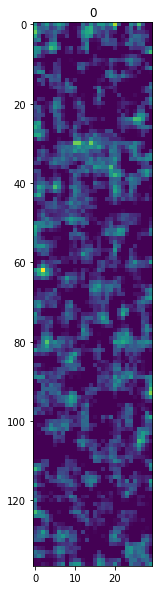

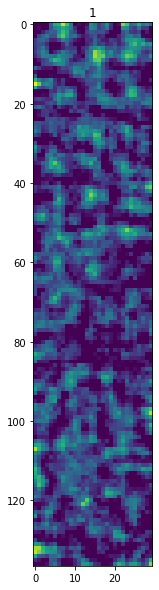

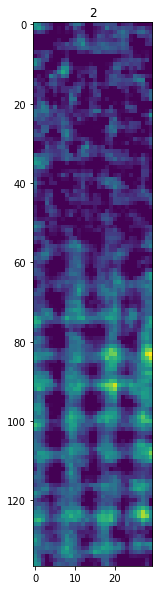

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

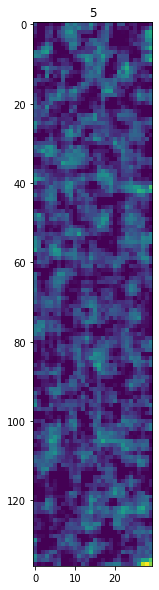

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

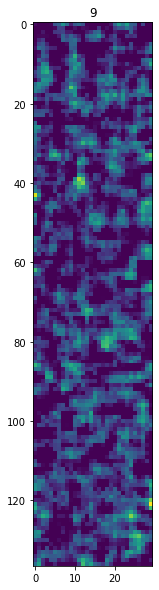

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

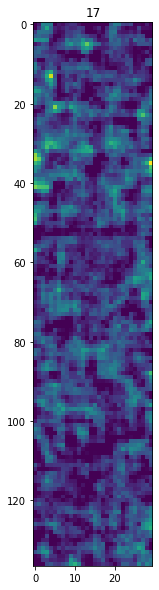

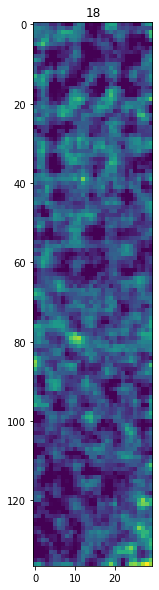

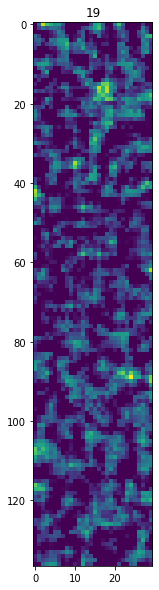

<Figure size 720x720 with 0 Axes>

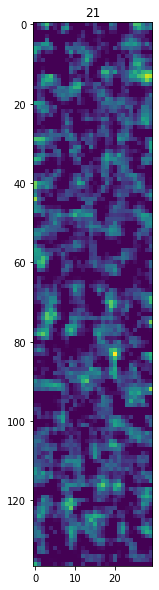

<Figure size 720x720 with 0 Axes>

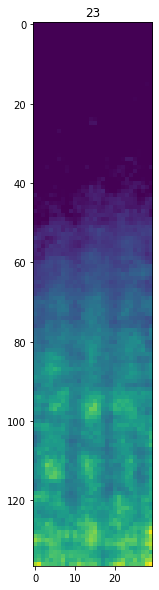

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

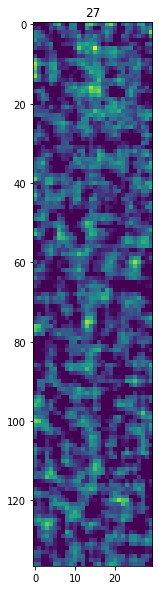

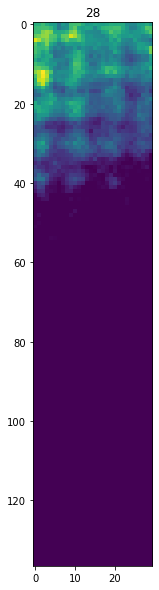

<Figure size 720x720 with 0 Axes>

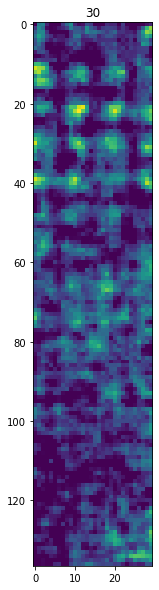

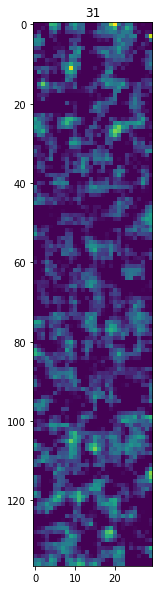

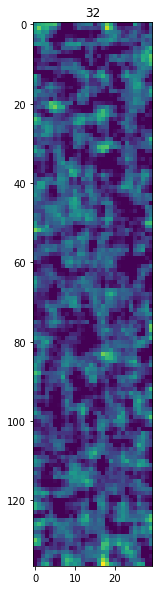

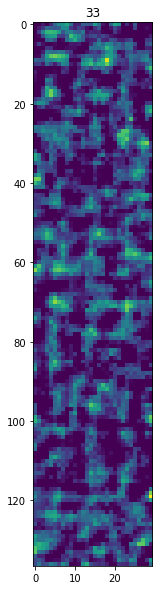

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [144]:
#new_model_l1=0.14902_epoch=684000.pkl
j=0
list_new = []
for i in range(36):
    plt.figure(figsize=(10,10))
    if np.sum(result_[:,i]>0):
        j+=1
        print(i)
        list_new.append(i)
        plt.title(str(i))
        plt.imshow(result_[:,i].reshape(137,30))
print(j)

In [50]:
# activated channel number
list_new

[0, 1, 2, 5, 9, 17, 18, 19, 21, 23, 27, 28, 30, 31, 32, 33, 35]

# Generate the movie 

In [147]:
# put decoder to cpu for movie generator
decoder.to('cpu')

Decoder(
  (cov1d_in): Conv1d(36, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (cov1d): Conv1d(128, 5, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv_block_1): conv_block(
    (cov1d_1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (cov1d_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (cov1d_3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (attention_1): MultiheadAttention(
      (out_proj): Linear(in_features=40, out_features=40, bias=True)
    )
    (attention_2): MultiheadAttention(
      (out_proj): Linear(in_features=40, out_features=40, bias=True)
    )
    (attention_3): MultiheadAttention(
      (out_proj): Linear(in_features=40, out_features=40, bias=True)
    )
    (norm_1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (norm_2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (norm_3): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.2, inplace=False)

In [137]:
def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

def find_nearest(array, value, averaging_number):
    """
    returns the indices nearest to a value in an image
    Parameters
    ----------
    array : float, array
        image to find the index closest to a value
    value : float
        value to find points near
    averaging_number : int
        number of points to find
    """
    idx = (np.abs(array-value)).argsort()[0:averaging_number]
    return idx

def savefig(filename, printing):

    """
    function that saves the figure

    :param filename: path to save file
    :type filename: string
    :param printing: contains information for printing
                     'dpi': int
                            resolution of exported image
                      print_EPS : bool
                            selects if export the EPS
                      print_PNG : bool
                            selects if print the PNG
    :type printing: dictionary

    """


    # Saves figures at EPS
    if printing['EPS']:
        plt.savefig(filename + '.eps', format='eps',
                    dpi=printing['dpi'], bbox_inches='tight')

    # Saves figures as PNG
    if printing['PNG']:
        plt.savefig(filename + '.png', format='png',
                    dpi=printing['dpi'], bbox_inches='tight')
        
        
def layout_fig(graph, mod=None):
    """
    Sets the layout of graphs in matplotlib in a pretty way based on the number of plots
    Parameters
    ----------
    graphs : int
        number of axes to make
    mod : int (optional)
        sets the number of figures per row
    Returns
    -------
    fig : matplotlib figure
        handel to figure being created.
    axes : numpy array (axes)
        numpy array of axes that are created.
    """
    print(graph)

    if mod is None:
        # Selects the number of columns to have in the graph
        if graph < 3:
            mod = 2
        elif graph < 5:
            mod = 3
        elif graph < 10:
            mod = 4
        elif graph < 17:
            mod = 5
        elif graph < 26:
            mod = 6
        elif graph < 37:
            mod = 7
       
    mod = graph//2
            
    mod =int(mod)
    graph = int(graph)

    # builds the figure based on the number of graphs and selected number of columns
    fig, axes = plt.subplots(graph // mod + (graph % mod > 0), mod,
                             figsize=(3 * mod, 3 * (graph // mod + (graph % mod > 0))))

    # deletes extra unneeded axes
    axes = axes.reshape(-1)
    for i in range(axes.shape[0]):
        if i + 1 > graph:
            fig.delaxes(axes[i])

    return (fig, axes)

In [138]:
from tqdm import tqdm
from os.path import join as pjoin

In [256]:
class generator:
    
    def __init__(self, 
                 model,
                 scaled_data,
                 embedding_out,
                 image, 
                 channels = None,
                 color_map = 'viridis'):
        
        self.model = model
        self.image = image
        
        # defines the colorlist
        self.cmap = plt.get_cmap(color_map)
        
        
#         if isinstance(model, type(DictionaryLearning())): 
#             def predictor(values): 
#                 return np.dot(values, model.components_)
#             self.predict = predictor
#             self.vector_length = scaled_data.shape[1]
#             self.embeddings = model.transform(scaled_data)
            
            
#         elif isinstance(model,type(model_builder(np.atleast_3d(scaled_data)))):
#             def predictor(values): 
#                 return model.decoder_model.predict(np.atleast_2d(values))
#             self.embeddings = model.encoder_model.predict(np.atleast_3d(scaled_data))
#             self.predict = predictor
#             self.vector_length = scaled_data.shape[1]
            
#         else:
#             raise Exception('The model is not an included model type '.format(dictonary_model))
            
        def predictor(values): 
                values = torch.from_numpy(np.atleast_2d(values))
                values = model(values.float())
                values = values.detach().numpy()
                
                return values
            
        self.embeddings = embedding_out
        self.predict = predictor
        self.vector_length = scaled_data.shape[1]
        self.number_of_spectrum = scaled_data.shape[2]
        if channels == None:
            self.channels = range(self.embeddings.shape[1])
        else: 
            self.channels = channels
        

    def generator_images(self, 
                        folder, 
                        ranges = None,
                        number_of_loops = 200, 
                        averaging_number = 100,
                        graph_layout = [4,16], 
                        y_lim = [-3.3,4.79],
                        xlabel = '',
                        ylabel = '',
                        xvalues = None,
                        in_radon=False
                        ):
        
        folder = make_folder(folder)
        
       #compare with zero values
        zero_values = np.zeros([1,36])
        zero_result = self.predict(zero_values).squeeze()
        
        for i in tqdm(range(number_of_loops)):

            # builds the figure
            fig, ax = plt.subplots(1+self.number_of_spectrum*(graph_layout[0] // graph_layout[1]) + (graph_layout[0] % graph_layout[1] > 0), graph_layout[1],
                                   figsize=(3 * graph_layout[1], 5*3 * (graph_layout[0] // graph_layout[1] + (graph_layout[0] % graph_layout[1] > 0))))
            ax = ax.reshape(-1)

            # loops around all of the embeddings
            for j, channel  in enumerate(self.channels):
                
                # checks if the value is None and if so skips tp next iteration
                if i is None:
                    continue
                    
                if xvalues is None:
                    xvalues = range(self.vector_length)
                
                if ranges is None: 
                    ranges =  np.stack((np.min(self.embeddings,axis=0),
                              np.max(self.embeddings,axis=0)), axis=1)

                # linear space values for the embeddings
                value = np.linspace(ranges[channel][0], ranges[channel][1], 
                                    number_of_loops)

                # finds the nearest point to the value and then takes the average
                # average number of points based on the averaging number
                idx = find_nearest(
                    self.embeddings[:,channel], 
                    value[i], 
                    averaging_number)
                
                # computes the mean of the selected index
                gen_value = np.mean(self.embeddings[idx], axis=0)
                
                # specifically updates the value of the embedding to visualize based on the
                # linear spaced vector
                gen_value[channel] = value[i]

                # generates the loop based on the model
                generated = self.predict(gen_value).squeeze()

                # plots the graph
   #             ax[j].imshow(generated, color=self.cmap((i + 1) / number_of_loops))
                if in_radon==True:
                    generated = iradon(generated)
            
                ax[j].imshow(self.embeddings[:, channel].reshape(self.image.shape[0:2]),
                             clim=ranges[channel])
                #                ax[j].imshow(image_, )
                
#                 print(self.number_of_spectrum)
#                 print(generated.shape)
                
                for k in range(self.number_of_spectrum):
                    
                    ind_k = j+len(self.channels)*(k+1)
 #                   print(ind_k)
                    ax[ind_k].plot(xvalues[:,k],generated[:,k],
                                        color=self.cmap((i + 1) / number_of_loops))
                    ax[ind_k].plot(xvalues[:,k],zero_result[:,k],color=self.cmap(0))
                    ax[ind_k].set_ylim(y_lim[0],y_lim[1])
            

                # formats the graph
   #             ax[j].set_ylim(y_lim[0],y_lim[1])
   #             ax[j].set_yticklabels('')
                ax[j].set_xlabel(xlabel)

                # gets the position of the axis on the figure
#                 pos = ax[j].get_position()

#                 # plots and formats the binary cluster map
#                 axes_in = plt.axes([pos.x0-0.18 , pos.y1, .12 * 4, .12 * 4])

                ## rotates the figure
                #if plot_format['rotation']:
                #    imageb, scalefactor = rotate_and_crop(embeddings[:, j].reshape(image.shape),
                #                                          angle=plot_format['angle'], frac_rm=plot_format['frac_rm'])
                #else:
                #    scalefactor = 1
                #    imageb = encode_small[:, j].reshape(60, 60)

                # plots the imagemap and formats
#                 axes_in.imshow(self.embeddings[:, channel].reshape(self.image.shape[0:2]), clim=ranges[channel])
#                 axes_in.set_yticklabels('')
#                 axes_in.set_xticklabels('')

            ax[0].set_ylabel(ylabel)
#            plt.tight_layout()

            savefig(pjoin(folder, f'{i:04d}_maps'), printing)
            plt.close(fig)   

In [2]:
import glob as glob
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip


def make_movie_1(movie_name, input_folder, output_folder, file_format,
                            fps, output_format = 'mp4', reverse = False):

    """
    Function which makes movies from an image series

    Parameters
    ----------
    movie_name : string
        name of the movie
    input_folder  : string
        folder where the image series is located
    output_folder  : string
        folder where the movie will be saved
    file_format  : string
        sets the format of the files to import
    fps  : numpy, int
        frames per second
    output_format  : string, optional
        sets the format for the output file
        supported types .mp4 and gif
        animated gif create large files
    reverse : bool, optional
        sets if the movie will be one way of there and back
    """

    # searches the folder and finds the files
    file_list = glob.glob('./' + input_folder + '/*.' + file_format)
#     print(input_folder)
#     print(file_list)

    # Sorts the files by number makes 2 lists to go forward and back
    list.sort(file_list)
    file_list_rev = glob.glob('./' + input_folder + '/*.' + file_format)
    list.sort(file_list_rev,reverse=True)

    # combines the file list if including the reverse
    if reverse:
        new_list = file_list + file_list_rev
    else:
        new_list = file_list
#        print(new_list)


    if output_format == 'gif':
        # makes an animated gif from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_gif(output_folder + '/{}.gif'.format(movie_name), fps=fps)
    else:
        
        # makes and mp4 from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_videofile(output_folder + '/{}.mp4'.format(movie_name), fps=fps)

In [213]:
ranges = list_new
str(ranges)

'[0, 1, 2, 5]'

In [278]:
scale_data = np.zeros([1,40,5])
images = np.zeros([137,30])

In [279]:
generator_4d_maker = generator(decoder,scale_data,result_, 
                                images, channels=ranges)

In [3]:
folders = 'DM3_New/30_31_32_33'

In [281]:
folders

'DM3_New/30_31_32_33'

In [282]:
generator_4d_maker.generator_images(folder = folders, xvalues=
                                    x_label,
                                 number_of_loops=200)

100%|██████████| 200/200 [09:46<00:00,  2.93s/it]


In [4]:
make_movie_1('30_31_32_33',
           folders,
           folders,
          'png',
          3)

t:   1%|          | 2/201 [00:00<00:15, 13.18it/s, now=None]

Moviepy - Building video DM3_New/30_31_32_33/30_31_32_33.mp4.
Moviepy - Writing video DM3_New/30_31_32_33/30_31_32_33.mp4



Moviepy - Done !
Moviepy - video ready DM3_New/30_31_32_33/30_31_32_33.mp4


6


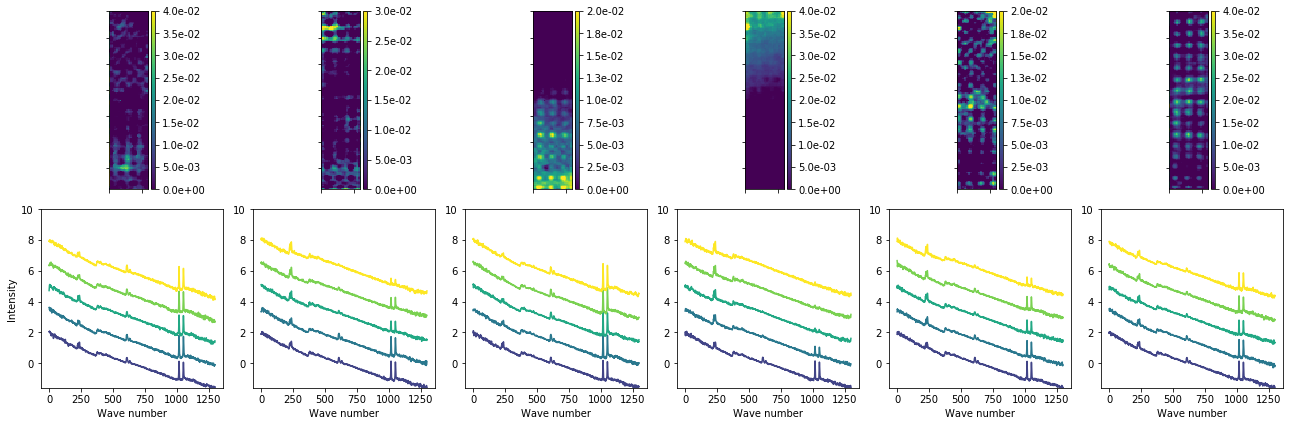

In [119]:
generate_piezo =viz.plot.generator_piezoresponse(decoder,
                            embedding_,
                            voltage,
                            ranges,
                            5,
                            100,
                            printing,
                            plot_format,
                            folder_piezoresponse_autoencoder,
                            y_scale=[-1.6, 10.0])